In [55]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

# So Version 0.2 eh?

The goal for this model is to work on the xC, yC columns to standardize them from 0-100 (instead of -100 to 100), the tricky bit here will be also adjusting the previous events co-ordinates to make sure I don't actually break anything. 


Some observations as I go here:

1. The previous event type was generally meant to be "hey was the previous shot a wrister or a slapshot", but is also picking up types of penalties that lead to a penalty shot. I'm wondering if I should include penalty shots in here at all, but will admit it's kinda interesting to see if it has an effect or not. (Really, I should find a way to mux it into a "is penalty shot" variable, but that's probably down the road a bit).
2. Looking at the data a little more closely, I can see I was accidentally including shootouts. Can probably get around this by excluding "Period 5" from the data.
3. Oy vey. I really messed up with the line `input_data2 = input_data2.applymap(lambda x: 1 if x == True else 0)` applying to EVERYTHING, not just the binary values. Time to fix that!
4. Digging more into code, for the 2022 season, only ~85% of recorded shots actually have x/y coordinates. That seems shockingly low!
5. Another 2.9% of shots just have 0,0 as the coordinates! I've read complaints, but truly had no idea it was this bad!
6. Another 13.8% of shots just happen to be at the faceoff dots! The good news is that the ratio of goals to shots is pretty unaltered by this, so we're not going to accidentally train the model to favor one over the other.

7. In total: Only ~70% of goals/shots have actual useful location data
8. Pretty sure my result data was completely broken. Time to try to fix it!


With all this in mind, I don't want to lose another -ton- of data due to previous events not having x/y co-ordinates. So I'll just keep them as NaN (boo). I'll also need to scrub and remove the "this event definitely happened at the faceoff circle" data and convert that to NaN as well. This will hopefully preserve the validity of the "change in angle" info I'm hoping the model will pick up on.

In [108]:
# Read in goal_shot_rows.csv
goal_shot_rows = pd.read_csv('goal_shot_rows.csv')

# remove all instances where Period is 5 or 0
goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

# create a subset of the dataframe, with only the 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC'
# 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC'

input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]

result_data = goal_shot_rows['Event']




# Remove all rows of input_data where xC or Yc is NaN
print(len(input_data))
print(input_data['Event'].value_counts())
input_data = input_data.dropna(subset=['xC', 'yC'])
print(len(input_data))
# remove all rows where xC = 0 and yC = 0


input_data = input_data[(input_data['xC'] != 0) | (input_data['yC'] != 0)]


print(len(input_data))
# remove all rows where xC = 69 or -69 and yC is 22 or -22
input_data = input_data[(input_data['xC'] != 69) & (input_data['xC'] != -69) | (input_data['yC'] != 22) & (input_data['yC'] != -22)]
print(len(input_data))
input_data = input_data[(input_data['xC'] != 20) & (input_data['xC'] != -20) | (input_data['yC'] != 22) & (input_data['yC'] != -22)]
print(len(input_data))
print(input_data['Event'].value_counts())

result_data = input_data['Event']
# change result_data to be 1 if it's "GOAL", 0 otherwise
result_data = result_data.apply(lambda x: 1 if x == "GOAL" else 0)

input_data = input_data.drop(columns=['Event'])

print(result_data.value_counts())


87487
Event
SHOT    78688
GOAL     8799
Name: count, dtype: int64
74578
72019
62482
61049
Event
SHOT    54915
GOAL     6134
Name: count, dtype: int64
Event
0    54915
1     6134
Name: count, dtype: int64


In [109]:
# Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
input_data_numeric = input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
input_data_categorical = pd.DataFrame()

for column in ['Strength', 'Type', 'prev_Event']:
    dummy_columns = pd.get_dummies(input_data[column])
    input_data_categorical = pd.concat([dummy_columns, input_data_categorical], axis=1)

for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
    dummy_columns = pd.get_dummies(input_data[column])
    
    # rename all columns with a prefix of "prev_"
    dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]

    input_data_categorical = pd.concat([input_data_categorical, dummy_columns], axis=1)


# change all True/False to 1/0
input_data_categorical = input_data_categorical.applymap(lambda x: 1 if x == True else 0)

# combine the two dataframes
input_data_combined = pd.concat([input_data_numeric, input_data_categorical], axis=1)

#set input_data2 to be all floats
input_data_combined = input_data_combined.astype(float)

C:\Users\JoshG\AppData\Local\Temp\ipykernel_29176\644659442.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  input_data_categorical = input_data_categorical.applymap(lambda x: 1 if x == True else 0)


c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


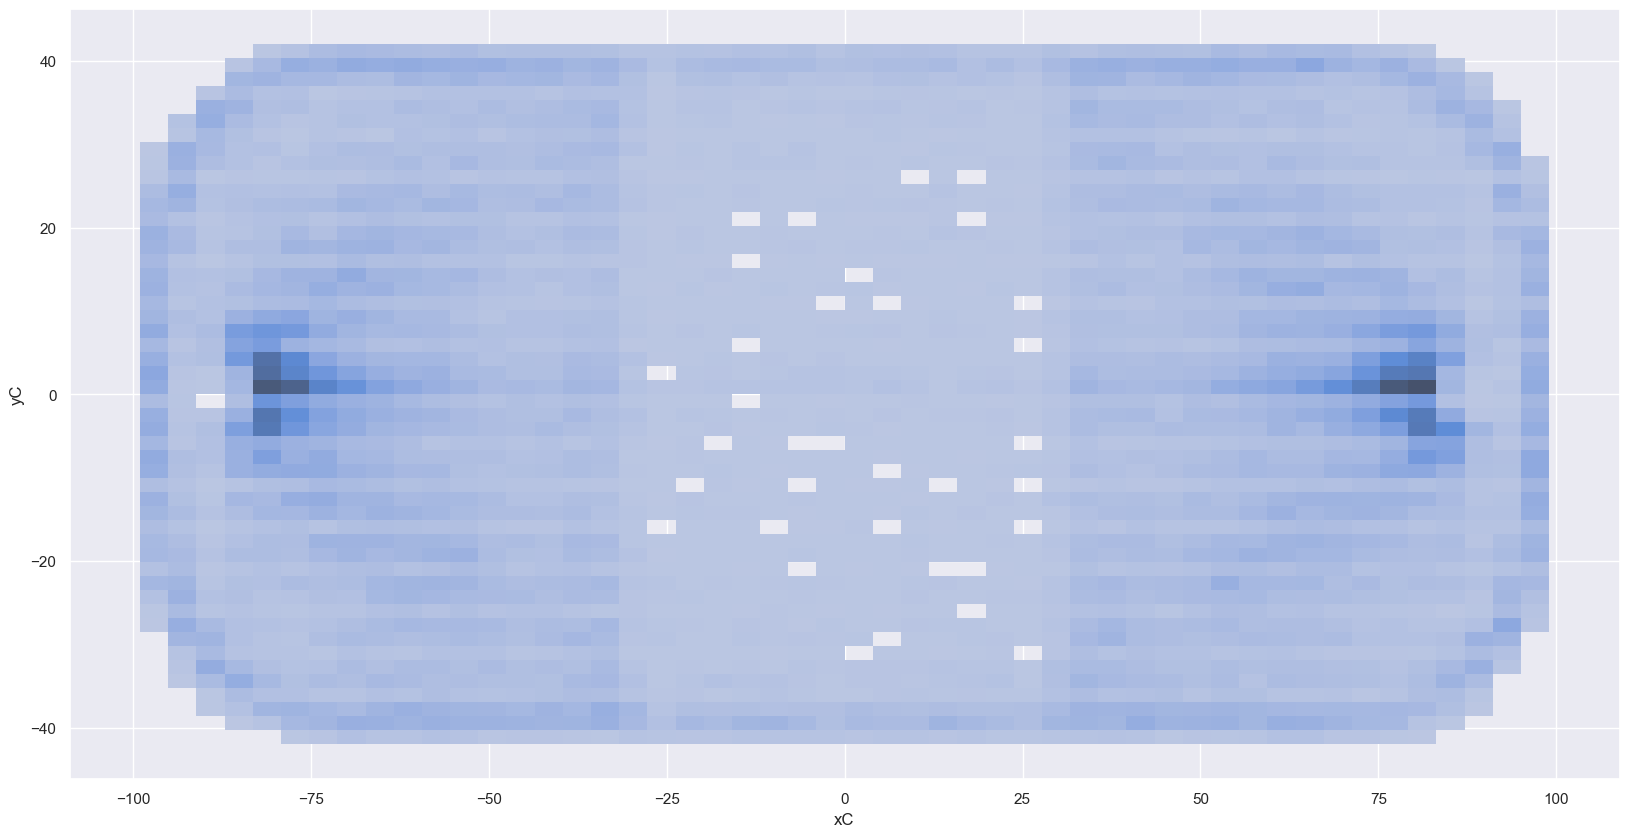

In [110]:
# let's do some data validation, and get the list of columns:
coord_df = pd.concat([input_data_combined['xC'], input_data_combined['yC']], axis=1)
sns.histplot(coord_df, x="xC", y="yC", bins=50)
sns.set_theme(rc={'figure.figsize':(20,10)})

# Get the most common combinations of xC and yC
# print(input_data_combined['xC'].value_counts())
# print(input_data_combined['yC'].value_counts())


In [111]:
# change all NaN numbers to 0
input_data_combined = input_data_combined.fillna(0)

In [112]:
x = torch.tensor(input_data_combined.values, dtype=torch.float32)
y = torch.tensor(result_data.values, dtype=torch.float32)

In [113]:
model = nn.Sequential(
    nn.Linear(71, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)

print(model)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Sequential(
  (0): Linear(in_features=71, out_features=120, bias=True)
  (1): ReLU()
  (2): Linear(in_features=120, out_features=60, bias=True)
  (3): ReLU()
  (4): Linear(in_features=60, out_features=1, bias=True)
  (5): Sigmoid()
)


In [114]:
n_epochs = 2000
batch_size = 3000
 
for epoch in range(n_epochs):
    for i in range(0, len(x), batch_size):
        Xbatch = x[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        #loss = loss_fn(y_pred, ybatch)
        loss = loss_fn(y_pred.squeeze(), ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'{epoch}, {loss}')


# compute accuracy (no_grad is optional)
y_pred = model(x)
 
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

0, 0.4354628324508667
1, 0.36439767479896545
2, 0.326209157705307
3, 0.3220076262950897
4, 0.3208581805229187
5, 0.3199954032897949
6, 0.3188171684741974
7, 0.31729429960250854
8, 0.3157847225666046
9, 0.3146976828575134
10, 0.3135438859462738
11, 0.3126435875892639
12, 0.3118395209312439
13, 0.3109837770462036
14, 0.31026414036750793
15, 0.30953148007392883
16, 0.3090105354785919
17, 0.30845269560813904
18, 0.3078936040401459
19, 0.30735328793525696
20, 0.30684298276901245
21, 0.30628472566604614
22, 0.3059399127960205
23, 0.3055175840854645
24, 0.3049580454826355
25, 0.3046286106109619
26, 0.30394890904426575
27, 0.30364060401916504
28, 0.30289196968078613
29, 0.30250421166419983
30, 0.30203771591186523
31, 0.3017590045928955
32, 0.30128344893455505
33, 0.301003098487854
34, 0.30071303248405457
35, 0.3004325330257416
36, 0.30014768242836
37, 0.2998864948749542
38, 0.29956483840942383
39, 0.29923000931739807
40, 0.2989385426044464
41, 0.29845932126045227
42, 0.2980353534221649
43, 0.2

(0.265, 0.28)

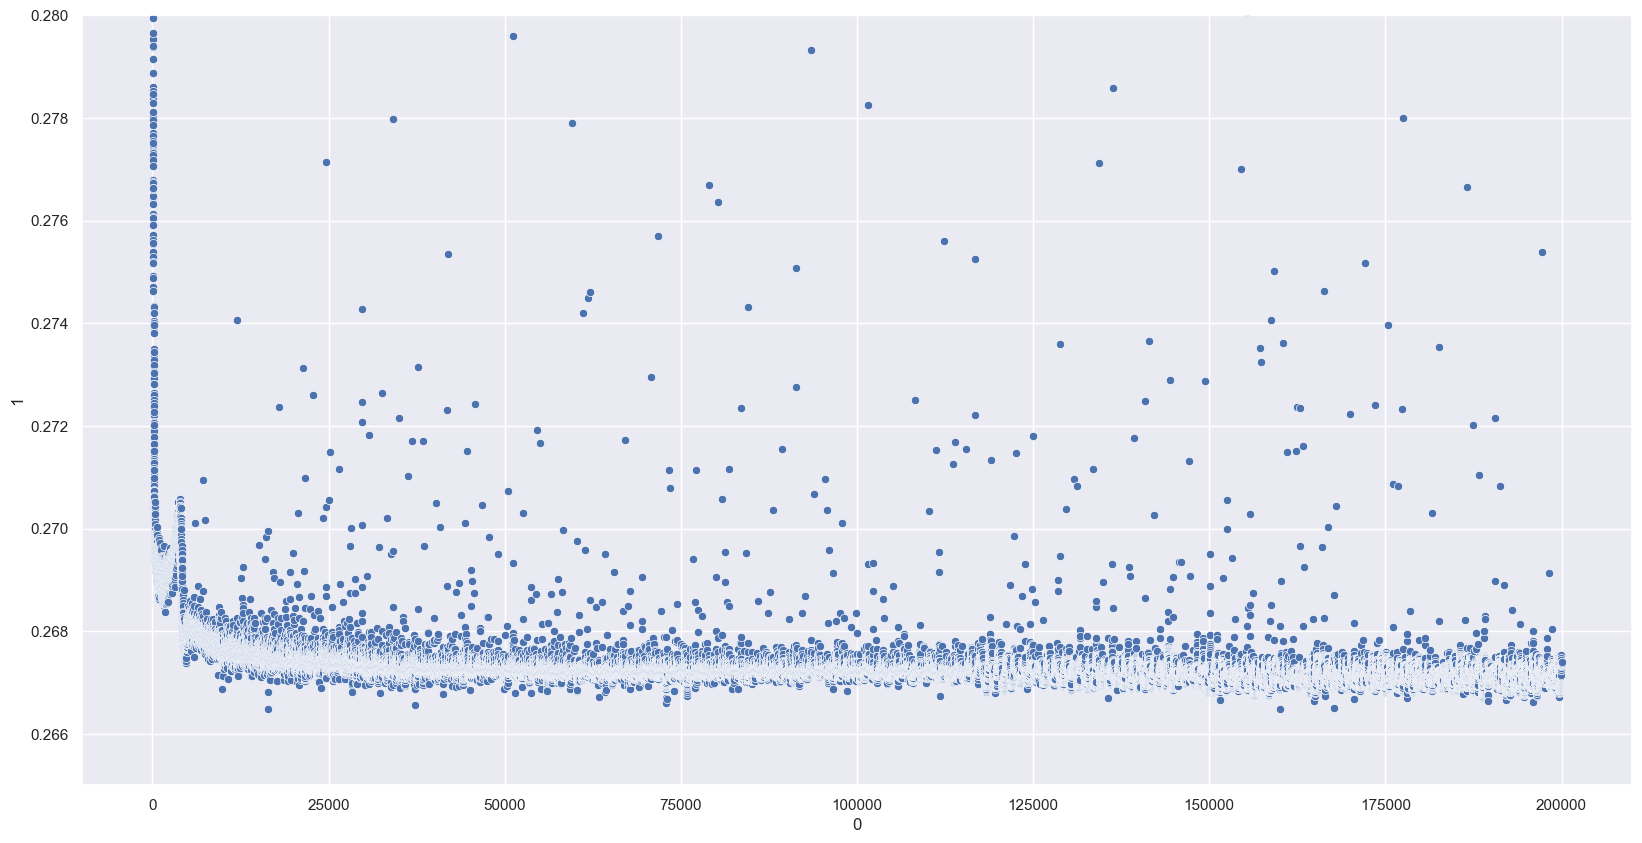

In [63]:
# open 0419Model.csv as a text file, and remove all non-numeric characters
data = ""
with open('0419Model.csv', 'r') as file:
    data = file.read()
    data = data.replace('Finished epoch ', '')
    # write it back to another file
with open('0419Model.csv', 'w') as file:
    file.write(data)


# read in the file as a dataframe
model_data = pd.read_csv('0419Model.csv', header=None)

# create a scatterplot of mode_data
sns.scatterplot(x=model_data[0], y=model_data[1])

# limit the scatterplot y axis to 0.25 to 0.3
plt.ylim(0.265, 0.28)

In [115]:
# Now save the model to a file for future use
torch.save(model.state_dict(), '0420Model.pt')

# Getting Top Players xG

In [116]:
filepath = '0420Model.pt'
model.load_state_dict(torch.load(filepath))
model.eval()

# Read in goal_shot_rows.csv
val_goal_shot_rows = pd.read_csv('2023-2024_shots.csv')

# remove all instances where Period is 5 or 0
val_goal_shot_rows = val_goal_shot_rows[val_goal_shot_rows['Period'] != 0]
val_goal_shot_rows = val_goal_shot_rows[val_goal_shot_rows['Period'] != 5]

# create a subset of the dataframe, with only the 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC'
# 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC'

val_input_data = val_goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]


# Remove all rows of val_input_data where xC or Yc is NaN
print(len(val_input_data))
print(val_input_data['Event'].value_counts())
val_input_data = val_input_data.dropna(subset=['xC', 'yC'])
print(len(val_input_data))
# remove all rows where xC = 0 and yC = 0
val_input_data = val_input_data[(val_input_data['xC'] != 0) | (val_input_data['yC'] != 0)]
print(len(val_input_data))
# remove all rows where xC = 69 or -69 and yC is 22 or -22
val_input_data = val_input_data[(val_input_data['xC'] != 69) & (val_input_data['xC'] != -69) | (val_input_data['yC'] != 22) & (val_input_data['yC'] != -22)]
print(len(val_input_data))
val_input_data = val_input_data[(val_input_data['xC'] != 20) & (val_input_data['xC'] != -20) | (val_input_data['yC'] != 22) & (val_input_data['yC'] != -22)]
print(len(val_input_data))
print(val_input_data['Event'].value_counts())

val_result_data = val_input_data['Event']
# change result_data to be 1 if it's "GOAL", 0 otherwise
val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

val_input_data = val_input_data.drop(columns=['Event'])


79594
Event
SHOT    71498
GOAL     8096
Name: count, dtype: int64
68051
65765
57383
56113
Event
SHOT    50250
GOAL     5863
Name: count, dtype: int64


In [117]:
# Quick sanity checking
print(val_result_data.value_counts())

Event
0    50250
1     5863
Name: count, dtype: int64


In [118]:

# Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
val_input_data_numeric = val_input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
val_input_data_categorical = pd.DataFrame()

for column in ['Strength', 'Type', 'prev_Event']:
    dummy_columns = pd.get_dummies(val_input_data[column])
    val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
    dummy_columns = pd.get_dummies(val_input_data[column])
    
    # rename all columns with a prefix of "prev_"
    dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]

    val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)


# change all True/False to 1/0
val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

# combine the two dataframes
val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

#set val_input_data2 to be all floats
val_input_data_combined = val_input_data_combined.astype(float)


# For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
for column in input_data_combined.columns:
    if column not in val_input_data_combined.columns:
        val_input_data_combined[column] = 0

# reduce val_input_data_combined to have the same columns as input_data_combined
val_input_data_combined = val_input_data_combined[input_data_combined.columns]

C:\Users\JoshG\AppData\Local\Temp\ipykernel_29176\2167638927.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


In [68]:
print(val_result_data)
# Get counts of most popular values in val_result_data
print(val_result_data.value_counts())

0        0
1        0
2        0
6        0
7        1
        ..
80087    0
80088    0
80089    1
80090    0
80091    0
Name: Event, Length: 56113, dtype: int64
Event
0    50250
1     5863
Name: count, dtype: int64


In [121]:
import pandas as pd
# For first 1000 rows of val_input_data_combined, predict if it's a goal or not
x = torch.tensor(val_input_data_combined.values, dtype=torch.float32)
y = torch.tensor(val_result_data.values, dtype=torch.float32)

# for first row of val_input_data_combined, predict if it's a goal or not

probablity_table = pd.DataFrame()
nan_count = 0

for i in range(1000):
    y_pred = model(x[i])
    # print(f"Goal status is {y[i]} and prediction is {y_pred[0]}")
    
    line = pd.DataFrame({'Goal': [y[i].item()], 'Chance': [y_pred[0].item()]})

    # check if y_pred is NaN
    if y_pred[0].item() != y_pred[0].item():
        print("y_pred is NaN")
        # line = pd.DataFrame({'Goal': [y[i].item()], 'Chance': [0.0]})
        nan_count += 1

    probablity_table = pd.concat([probablity_table, line])

# sort probablity_table by 'Chance' in descending order
probablity_table = probablity_table.sort_values(by='Chance', ascending=False)

print(probablity_table)
print(nan_count)


y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred is NaN
y_pred

In [20]:
print(accuracy)

tensor(0.5896)
